# NLP Topic Modeling: Obama VS Trump (Round I)

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

### Import packages

In [28]:
# ! pip install WordCloud
# ! pip install pyLDAvis

In [30]:
import pandas as pd
import numpy as np
import re

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from wordcloud import WordCloud
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
# import pickle

# NLP with sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

### Import data

In [3]:
# https://www.kaggle.com/austinreese/trump-tweets
df_trump = pd.read_csv('./datasets/trump_tweets.csv')
# https://www.kaggle.com/datacrux/barack-obama-twitterdata-from-20122019
df_obama = pd.read_csv('./datasets/obama_tweets.csv')

### Explore data

In [4]:
df_trump.head(1)

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN


In [5]:
df_obama.head(1)

,Date,Username,Tweet-text,Tweet Link,Retweets,Likes,TweetImageUrl,Image
0,2019/04/10_17:08,https://twitter.com/BarackObama,From a big NBA fan congrats to future Hall of ...,https://twitter.com/BarackObama/status/1116130...,20954,175133,NaN,NaN


### Data preprocessing

#### Deleting links

In [6]:
# pic.twitter.com
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('pic.twitter.com/\w\w\w\w\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('pic.twitter.com/\w\w\w\w\w\w\w\w\w\w', '', x))

In [7]:
# tinyurl
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('http://tinyurl.com/\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('http://tinyurl.com/\w\w\w\w\w\w', '', x))

In [8]:
# bit.ly
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('http://bit.ly/\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('http://bit.ly/\w\w\w\w\w\w', '', x))

In [9]:
# Others:
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))

#### Remove punctuation & Lower casing

In [10]:
# Remove punctuation
df_trump['tweet'] = df_trump['content'].map(lambda x: re.sub('[,\.!?]', '', x))
df_obama['tweet'] = df_obama['Tweet-text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the tweets to lowercase
df_trump['tweet'] = df_trump['tweet'].map(lambda x: x.lower())
df_obama['tweet'] = df_obama['tweet'].map(lambda x: x.lower())

### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words.

#### Trump

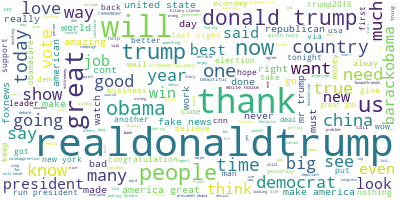

In [11]:
# Join the different processed tweets together
trump_tweets = ','.join(list(df_trump['tweet'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(trump_tweets)

# Visualize the word cloud
wordcloud.to_image()

#### Obama

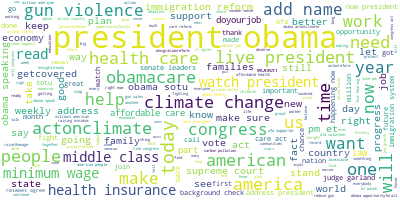

In [12]:
# Join the different processed tweets together
obama_tweets = ','.join(list(df_obama['tweet'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(obama_tweets)

# Visualize the word cloud
wordcloud.to_image()

### Prepare text for LDA Analysis

Let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of tweets into lists of vectors, all with length equal to the vocabulary. We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

In [13]:
# Helper function

def plot_10_most_common_words(count_data, count_vectorizer):
    
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 8))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

#### Trump

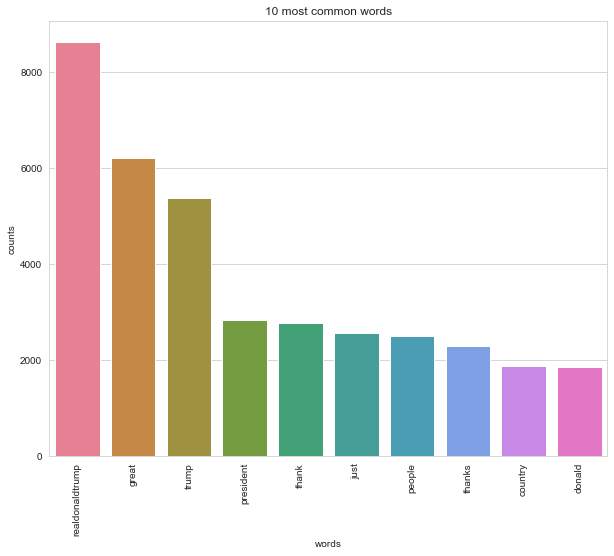

In [14]:
# Initialise the count vectorizer with the English stop words
count_vectorizer_trump = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data_trump = count_vectorizer_trump.fit_transform(df_trump['tweet'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_trump, count_vectorizer_trump)

#### Obama

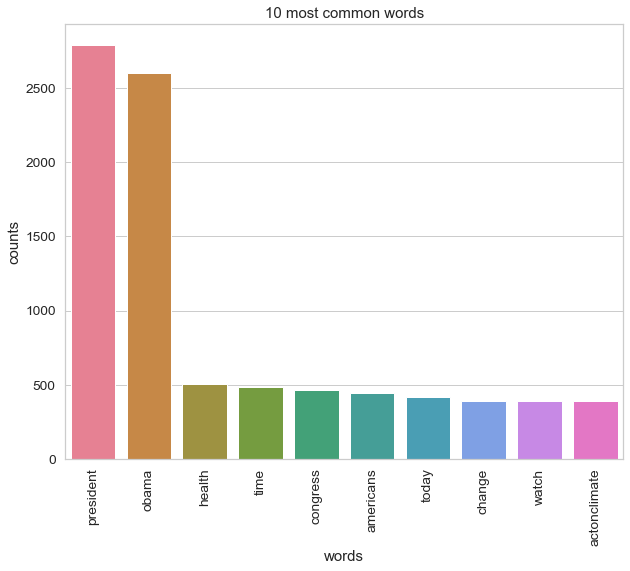

In [15]:
# Initialise the count vectorizer with the English stop words
count_vectorizer_obama = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data_obama = count_vectorizer_obama.fit_transform(df_obama['tweet'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_obama, count_vectorizer_obama)

### LDA model training and results visualization

In [21]:
# Helper function

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [22]:
# Tweak the two parameters below
number_topics = 5
number_words = 5

In [23]:
# Create and fit the LDA model
lda_trump = LDA(n_components=number_topics, n_jobs=-1)
lda_trump.fit(count_data_trump)
lda_obama = LDA(n_components=number_topics, n_jobs=-1)
lda_obama.fit(count_data_obama)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

#### Trump

In [24]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_trump, count_vectorizer_trump, number_words)

Topics found via LDA:

Topic #0:
great thank realdonaldtrump trump news

Topic #1:
trump realdonaldtrump great donald new

Topic #2:
obama president just democrats people

Topic #3:
realdonaldtrump president run thanks country

Topic #4:
realdonaldtrump great thank thanks trump2016


#### Obama

In [25]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_obama, count_vectorizer_obama, number_words)

Topics found via LDA:

Topic #0:
president obama ofa watch make

Topic #1:
president obama change actonclimate climate

Topic #2:
time congress gun obama president

Topic #3:
president obama health care immigration

Topic #4:
president obama jobs senate economy


### Analyzing LDA model results

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

- Better understanding and interpreting individual topics.
- Better understanding the relationships between the topics.

In [ ]:
%%time
LDAvis_prepared_trump = sklearn_lda.prepare(lda_trump, count_data_trump, count_vectorizer_trump)
pyLDAvis.save_html(LDAvis_prepared_trump, './pyLDAvis/ldavis_prepared_trump_'+ str(number_topics) +'.html')

In [ ]:
%%time
LDAvis_prepared_obama = sklearn_lda.prepare(lda_obama, count_data_obama, count_vectorizer_obama)
pyLDAvis.save_html(LDAvis_prepared_obama, './pyLDAvis/ldavis_prepared_obama_'+ str(number_topics) +'.html')